## Data Collection

### 1. Download audio data from Google

In [ ]:
!pip -qqq install yt-dlp

In [ ]:
from yt_dlp import YoutubeDL
import os
import re

In [ ]:
class YouTubeAudioDownloader:
    def __init__(self, output_folder):
        self.output_folder = os.path.abspath(output_folder)
        self.audio_files_dict = {}

    def get_safe_filename(self, filename):
        safe_filename = re.sub(r'[^\w\-.]', '_', filename)
        safe_filename = re.sub(r'_+', '_', safe_filename)
        safe_filename = safe_filename[:50].strip('_')
        return safe_filename

    def download_audio(self, video_url):
        try:
            ydl_opts = {
                'format': 'bestaudio/best',
                'postprocessors': [{
                    'key': 'FFmpegExtractAudio',
                    'preferredcodec': 'mp3',
                    'preferredquality': '192',
                }],
                'outtmpl': os.path.join(self.output_folder, '%(title)s.%(ext)s'),
            }

            with YoutubeDL(ydl_opts) as ydl:
                info = ydl.extract_info(video_url, download=True)
                filename = ydl.prepare_filename(info)
                base, ext = os.path.splitext(filename)
                new_file = base + '.mp3'

            print(f"Audio file downloaded: {new_file}")
            self.audio_files_dict[video_url] = new_file
            return new_file
        except Exception as e:
            print(f"Error downloading audio from {video_url}: {str(e)}")
            return None

    def download_multiple_audios(self, video_urls):
        for url in video_urls:
            print(f"Processing video: {url}")
            audio_file = self.download_audio(url)
            if audio_file is None:
                print(f"Failed to download audio from video: {url}")
        return self.audio_files_dict

In [ ]:
downloader = YouTubeAudioDownloader(output_folder="./data")

# List of video URLs
video_urls = ["https://www.youtube.com/watch?v=9VMZRCqFANQ",
                "https://www.youtube.com/watch?v=Lq9F8fWTIjI"]

# Download audios from multiple videos
audio_files = downloader.download_multiple_audios(video_urls)

print("Downloaded audio files:")
for audio_file in audio_files:
    print(audio_file)


Processing video: https://www.youtube.com/watch?v=9VMZRCqFANQ
[youtube] Extracting URL: https://www.youtube.com/watch?v=9VMZRCqFANQ
[youtube] 9VMZRCqFANQ: Downloading webpage
[youtube] 9VMZRCqFANQ: Downloading ios player API JSON
[youtube] 9VMZRCqFANQ: Downloading mweb player API JSON
[youtube] 9VMZRCqFANQ: Downloading player 62ccfae7
[youtube] 9VMZRCqFANQ: Downloading m3u8 information
[info] 9VMZRCqFANQ: Downloading 1 format(s): 251
[download] Destination: d:\mmrag\data\What is Manufacturing Execution System (MES)？.webm
[download] 100% of    6.00MiB in 00:00:02 at 2.97MiB/s   


ERROR: Postprocessing: ffprobe and ffmpeg not found. Please install or provide the path using --ffmpeg-location


Error downloading audio from https://www.youtube.com/watch?v=9VMZRCqFANQ: ERROR: Postprocessing: ffprobe and ffmpeg not found. Please install or provide the path using --ffmpeg-location
Failed to download audio from video: https://www.youtube.com/watch?v=9VMZRCqFANQ
Processing video: https://www.youtube.com/watch?v=Lq9F8fWTIjI
[youtube] Extracting URL: https://www.youtube.com/watch?v=Lq9F8fWTIjI
[youtube] Lq9F8fWTIjI: Downloading webpage
[youtube] Lq9F8fWTIjI: Downloading ios player API JSON
[youtube] Lq9F8fWTIjI: Downloading mweb player API JSON
[youtube] Lq9F8fWTIjI: Downloading m3u8 information


[info] Lq9F8fWTIjI: Downloading 1 format(s): 251
[download] Destination: d:\mmrag\data\What is MES？ Manufacturing Execution Systems.webm
[download] 100% of    5.99MiB in 00:00:01 at 5.86MiB/s   


ERROR: Postprocessing: ffprobe and ffmpeg not found. Please install or provide the path using --ffmpeg-location


Error downloading audio from https://www.youtube.com/watch?v=Lq9F8fWTIjI: ERROR: Postprocessing: ffprobe and ffmpeg not found. Please install or provide the path using --ffmpeg-location
Failed to download audio from video: https://www.youtube.com/watch?v=Lq9F8fWTIjI
Downloaded audio files:


In [ ]:
audio_files

{}

### 2. Transcriptions Generation With Whisper

In [ ]:
!pip -qqq install openai-whisper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 10.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.5 MB/s eta 0:00:00


In [ ]:
import whisper
import torch

In [ ]:
class AudioTranscriber:
    def __init__(self, input_folder):
        self.input_folder = os.path.abspath(os.path.join(os.getcwd(), input_folder))
        self.whisper_model = None
        self.transcriptions_dict = {}

    def transcribe_audio(self, audio_file):
        try:
            if not os.path.exists(audio_file):
                print(f"Audio file not found: {audio_file}")
                return None

            file_size = os.path.getsize(audio_file)
            if file_size == 0:
                print(f"Audio file is empty: {audio_file}")
                return None

            transcription = self.whisper_model.transcribe(audio_file)
            return transcription["text"]
        except Exception as e:
            print(f"Error in transcribe_audio: {str(e)}")
            return None

    def transcribe_all_audios(self, audio_files_dict):
        for url, audio_path in audio_files_dict.items():
            if not audio_path.endswith('.mp3'):
                print(f"Skipping non-mp3 file: {audio_path}")
                continue

            transcription = self.transcribe_audio(audio_path)

            if transcription is not None:
                # Add to transcriptions dictionary
                self.transcriptions_dict[url] = {
                    'url': url,
                    'audio_path': audio_path,
                    'transcription': transcription
                }
            else:
                print(f"Failed to transcribe audio: {audio_path}")

        return self.transcriptions_dict

In [ ]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model
whisper_model = whisper.load_model("medium", device=device)


100%|█████████████████████████████████████| 1.42G/1.42G [00:22<00:00, 67.0MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

In [ ]:
# Initialize the AudioTranscriber
transcriber = AudioTranscriber(input_folder=r"./data")


# Initialize your Whisper model
transcriber.whisper_model = whisper_model

# Transcribe all audios in the input folder
transcriptions_dict = transcriber.transcribe_all_audios(audio_files)

for url, data in transcriptions_dict.items():
    print(f"URL: {url}")
    print(f"Audio file: {data['audio_path']}")
    print(f"Transcription: {data['transcription'][:100]}...")  # Print first 100 characters
    print("---")

URL: https://www.youtube.com/watch?v=9VMZRCqFANQ
Audio file: /content/data/What is Manufacturing Execution System (MES)？.mp3
Transcription:  In this video, we are going to learn what is MES system. Why it's important to learn MES system as ...
---
URL: https://www.youtube.com/watch?v=Lq9F8fWTIjI
Audio file: /content/data/What is MES？ Manufacturing Execution Systems.mp3
Transcription:  The question is, what is MES? And for those of you who know what MES is, I encourage you to watch t...
---


In [ ]:
transcriptions_dict

{'https://www.youtube.com/watch?v=9VMZRCqFANQ': {'url': 'https://www.youtube.com/watch?v=9VMZRCqFANQ',
  'audio_path': '/content/data/What is Manufacturing Execution System (MES)？.mp3',
  'transcription': " In this video, we are going to learn what is MES system. Why it's important to learn MES system as an automation engineer. There are few concepts which are leading to MES system. So we would start our discussion from the foundation and then eventually we will talk about MES system. Before understanding MES system, it's very important to understand manufacturing industry because MES system is linked with manufacturing industry. Before talking about manufacturing industry, it's important to understand what is manufacturing. Manufacturing is a creation or production of the goods with the help of equipment, labor, machine, tools and chemical or biological processing. When we talk about example of major manufacturers in North America, it includes General Electric Corporation, General Ele

In [ ]:
# Get the first key-value pair in the dictionary
first_item = next(iter(transcriptions_dict.items()))

# Extract the transcription from the first item
first_transcription = first_item[1]['transcription']

first_transcription

" In this video, we are going to learn what is MES system. Why it's important to learn MES system as an automation engineer. There are few concepts which are leading to MES system. So we would start our discussion from the foundation and then eventually we will talk about MES system. Before understanding MES system, it's very important to understand manufacturing industry because MES system is linked with manufacturing industry. Before talking about manufacturing industry, it's important to understand what is manufacturing. Manufacturing is a creation or production of the goods with the help of equipment, labor, machine, tools and chemical or biological processing. When we talk about example of major manufacturers in North America, it includes General Electric Corporation, General Electric, Pfizer, example in Europe would be Siemens, Airbus. When we talk about example of the manufacturing industry or manufacturers in Asia, you would definitely name higher, Huawei, Lenovo, Toyota, Samsu

In [ ]:
import json

audio_data = [
    {
        "url": value["url"],
        "audio_path": value["audio_path"],
        "transcription": value["transcription"]
    }
    for value in transcriptions_dict.values()
]

# Print the result
print(json.dumps(audio_data, indent=2))

[
  {
    "url": "https://www.youtube.com/watch?v=9VMZRCqFANQ",
    "audio_path": "/content/data/What is Manufacturing Execution System (MES)\uff1f.mp3",
    "transcription": " In this video, we are going to learn what is MES system. Why it's important to learn MES system as an automation engineer. There are few concepts which are leading to MES system. So we would start our discussion from the foundation and then eventually we will talk about MES system. Before understanding MES system, it's very important to understand manufacturing industry because MES system is linked with manufacturing industry. Before talking about manufacturing industry, it's important to understand what is manufacturing. Manufacturing is a creation or production of the goods with the help of equipment, labor, machine, tools and chemical or biological processing. When we talk about example of major manufacturers in North America, it includes General Electric Corporation, General Electric, Pfizer, example in Euro

###Processing PDFs

In [ ]:
%%bash

pip -qqq install pdfminer.six
pip -qqq install pillow-heif==0.3.2
pip -qqq install matplotlib
pip -qqq install unstructured-inference
pip -qqq install unstructured-pytesseract
pip -qqq install tesseract-ocr
pip -qqq install unstructured

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 9

  ERROR: Failed building wheel for tesseract-ocr
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tesseract-ocr)


`Unstructured` module depends on tesseract, and using the following statements performs a successful installation.

In [ ]:
%%bash
apt install tesseract-ocr
apt install libtesseract-dev

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (13.7 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123632 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-eng_1%3a4.00~git

In [ ]:
pip install pi-heif


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.5 MB/s eta 0:00:00


In [ ]:
from unstructured.partition.pdf import partition_pdf

In [ ]:
esg_report_path = "/content/MES.pdf"

`Poppler` module is also used as backend for PDF processing.

In [ ]:
%%bash
sudo apt-get update
apt-get install poppler-utils

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,190 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,523 kB]
Get:13 http://archive.ubuntu.com/ubuntu 

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
esg_report_raw_data =partition_pdf(
    filename=esg_report_path,
    strategy="hi_res",
    extract_images_in_pdf=True,
    extract_image_block_to_payload=False,
    extract_image_block_output_dir="./data/images/"
    )

yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

In [ ]:
esg_report_raw_data

#### 1. Extract Textual Component

In [ ]:
from unstructured.documents.elements import NarrativeText

In [ ]:
def extract_text_with_metadata(esg_report, source_document):

    text_data = []
    paragraph_counters = {}

    for element in esg_report:
        if isinstance(element, NarrativeText):
            page_number = element.metadata.page_number

            if page_number not in paragraph_counters:
                paragraph_counters[page_number] = 1
            else:
                paragraph_counters[page_number] += 1

            paragraph_number = paragraph_counters[page_number]

            text_content = element.text
            text_data.append({
                "source_document": source_document,
                "page_number": page_number,
                "paragraph_number": paragraph_number,
                "text": text_content
            })

    return text_data

In [ ]:
extracted_data = extract_text_with_metadata(esg_report_raw_data, esg_report_path)


In [ ]:
extracted_data

[{'source_document': '/content/MES.pdf',
  'page_number': 1,
  'paragraph_number': 1,
  'text': 'Rolf Blumenthal, Werum Software & Systems'},
 {'source_document': '/content/MES.pdf',
  'page_number': 1,
  'paragraph_number': 2,
  'text': 'Parsippany, NJ / Lueneburg, Germany'},
 {'source_document': '/content/MES.pdf',
  'page_number': 1,
  'paragraph_number': 3,
  'text': 'This article has originally been published in the German magazine “Die pharmazeutische Industrie”.'},
 {'source_document': '/content/MES.pdf',
  'page_number': 1,
  'paragraph_number': 4,
  'text': 'Optimizing the pharmaceutical supply chain by means of MES'},
 {'source_document': '/content/MES.pdf',
  'page_number': 1,
  'paragraph_number': 5,
  'text': 'page 1 of 28'},
 {'source_document': '/content/MES.pdf',
  'page_number': 2,
  'paragraph_number': 1,
  'text': 'Manufacturing Execution Systems (MES) enable the pharmaceutical industry to reduce production costs and increase compliance with regulatory requirements s

#### 2. Extract Image Components

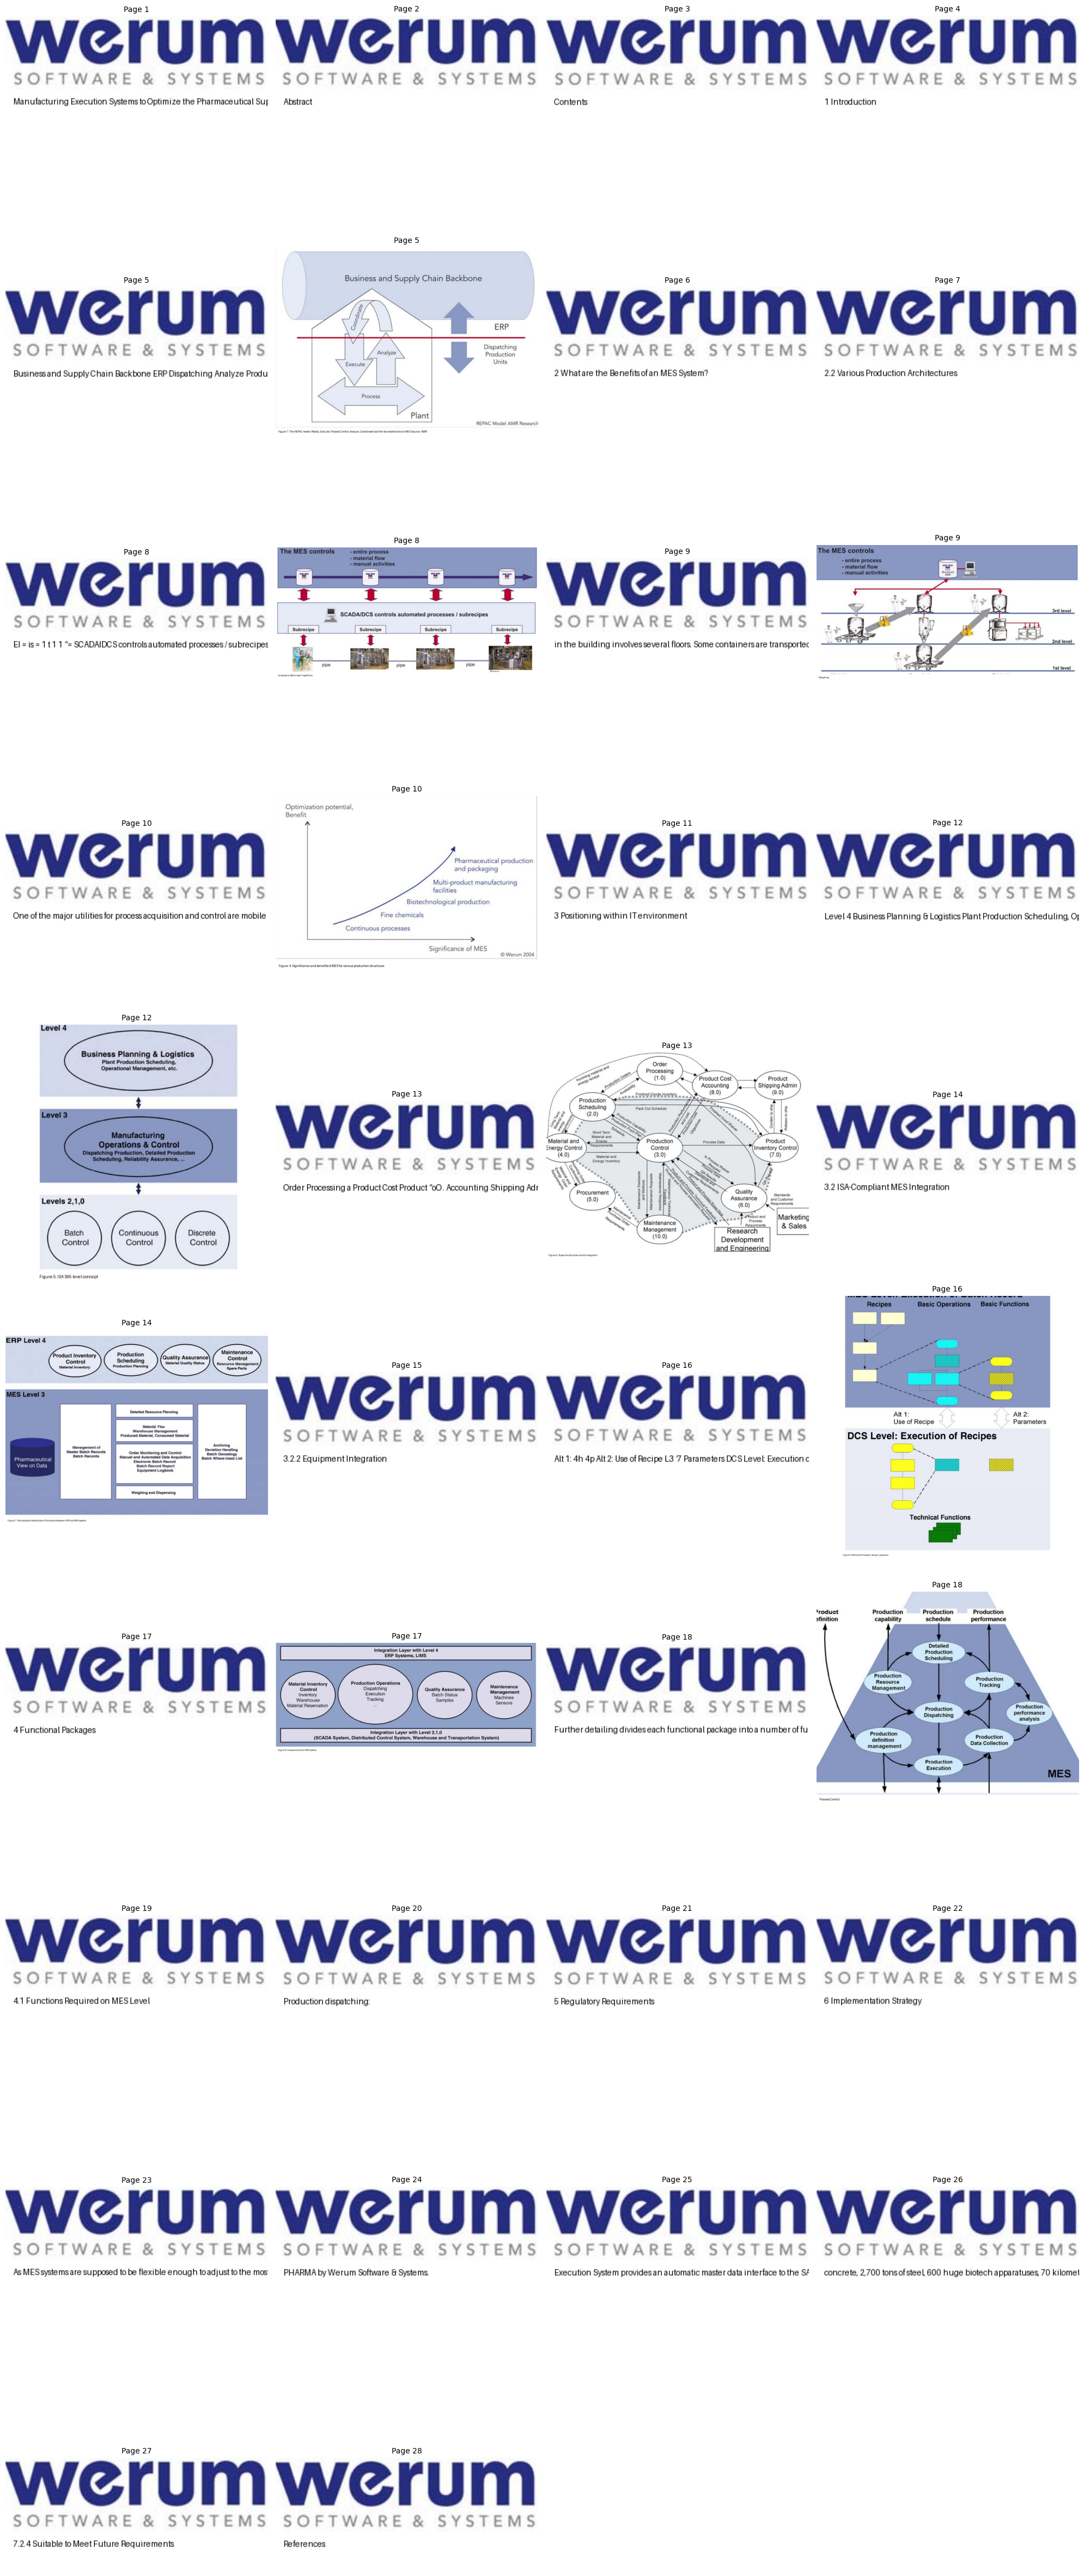

In [ ]:
from unstructured.documents.elements import Image, Text
from PIL import Image as PILImage, ImageDraw
import matplotlib.pyplot as plt
import math

def extract_image_metadata_with_text(esg_report, source_document):
    image_data = []
    for i, element in enumerate(esg_report):
        if isinstance(element, Image):
            page_number = element.metadata.page_number
            image_path = element.metadata.image_path if hasattr(element.metadata, 'image_path') else None

            # Include text elements immediately following the image
            text_below = ""
            if i + 1 < len(esg_report) and isinstance(esg_report[i + 1], Text):
                text_below = esg_report[i + 1].text.strip()

            image_data.append({
                "source_document": source_document,
                "page_number": page_number,
                "image_path": image_path,
                "text_below": text_below
            })

    return image_data


def display_images_with_text_from_metadata(extracted_image_data, images_per_row=4):
    valid_images = [img for img in extracted_image_data if img['image_path']]
    if not valid_images:
        print("No valid image data available.")
        return

    num_images = len(valid_images)
    num_rows = math.ceil(num_images / images_per_row)

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, 5 * num_rows))
    axes = axes.flatten() if num_rows > 1 else [axes]

    for ax, img_data in zip(axes, valid_images):
        try:
            # Load the image
            img = PILImage.open(img_data['image_path'])

            # Annotate with the text below the image
            annotated_img = annotate_image_with_text(img, img_data['text_below'])

            ax.imshow(annotated_img)
            ax.axis('off')
            ax.set_title(f"Page {img_data['page_number']}", fontsize=10)
        except Exception as e:
            print(f"Error loading image {img_data['image_path']}: {str(e)}")
            ax.text(0.5, 0.5, f"Error loading image\n{str(e)}", ha='center', va='center')
            ax.axis('off')

    for ax in axes[num_images:]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()


def annotate_image_with_text(image, text):
    if not text:
        return image

    # Create a new image with additional space for the text
    width, height = image.size
    new_height = height + 50  # Add 50px for text
    annotated_img = PILImage.new("RGB", (width, new_height), (255, 255, 255))
    annotated_img.paste(image, (0, 0))

    # Draw the text below the image
    draw = ImageDraw.Draw(annotated_img)
    draw.text((10, height + 10), text, fill="black")  # Add a margin of 10px from the bottom

    return annotated_img


# Example usage
extracted_image_data = extract_image_metadata_with_text(esg_report_raw_data, esg_report_path)
display_images_with_text_from_metadata(extracted_image_data)


#### 2. Image summarization

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration

def load_huggingface_image_captioning_model():
    """
    Load and return the Hugging Face BLIP processor and model for image captioning.
    """
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
    return processor, model

# Load the model and processor
processor, model = load_huggingface_image_captioning_model()


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
from PIL import Image as PILImage
import base64
import os

def extract_image_metadata_with_summary(esg_report_raw_data, esg_report_path, processor, model):
    """
    Extract image metadata and generate summaries using a preloaded Hugging Face model and processor.
    """
    image_data = []

    for element in esg_report_raw_data:
        if "Image" in str(type(element)):
            page_number = element.metadata.page_number if hasattr(element.metadata, 'page_number') else None
            image_path = element.metadata.image_path if hasattr(element.metadata, 'image_path') else None

            if image_path and os.path.exists(image_path):
                # Load and preprocess the image
                image = PILImage.open(image_path).convert("RGB")
                inputs = processor(image, return_tensors="pt")

                # Generate the description using the model
                outputs = model.generate(**inputs)
                description = processor.decode(outputs[0], skip_special_tokens=True)

                # Read the image file and encode it to base64
                with open(image_path, "rb") as image_file:
                    encoded_string = base64.b64encode(image_file.read()).decode('utf-8')

                image_data.append({
                    "source_document": esg_report_path,
                    "page_number": page_number,
                    "image_path": image_path,
                    "description": description,
                    "base64_encoding": encoded_string
                })
            else:
                print(f"Warning: Image file not found or path not available for image on page {page_number}")

    return image_data

# Example usage
extracted_image_data = extract_image_metadata_with_summary(esg_report_raw_data, esg_report_path, processor, model)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
# Get the first key-value pair in the dictionary
sixth_image_details = extracted_image_data[:20]

sixth_image_details

[{'source_document': '/content/MES.pdf',
  'page_number': 1,
  'image_path': './data/images/figure-1-1.jpg',
  'description': 'the logo for the software company',
  'base64_encoding': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABdAU8DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9o

## Data Upload

### 0. Connect to the Weaviate instance

In [ ]:
!pip -qqq install weaviate-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.0/387.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.8/223.8 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 23.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.0 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 5.29.0 which is incompatible.


In [ ]:
import weaviate

In [ ]:
userdata = {
    'URL': 'https://jqx2z1tkqs2cvohiq6nvxw.c0.asia-southeast1.gcp.weaviate.cloud',
    'APIKEY': 'XhatAAoFshT4XPsQu83xTkUAvYAi0XyASDgv'
}
URL = userdata.get('URL')
APIKEY = userdata.get('APIKEY')


In [ ]:
URL

'https://jqx2z1tkqs2cvohiq6nvxw.c0.asia-southeast1.gcp.weaviate.cloud'

In [ ]:
# Connect to a WCS instance
client = weaviate.connect_to_wcs(
    cluster_url=URL,
    auth_credentials=weaviate.auth.AuthApiKey(APIKEY)
)

In [ ]:
client

In [ ]:
import weaviate.classes.config as wc
from weaviate.util import generate_uuid5
import weaviate.classes.query as wq

# Hugging Face embedding setup
# Keep the original embedding model for vectorization
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Hugging Face model and tokenizer for embedding generation
hf_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
hf_model = AutoModel.from_pretrained(MODEL_NAME).to(device)

In [ ]:
def get_embedding_hf(text: str):
    """
    Generate embeddings using a Hugging Face model.
    """
    inputs = hf_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = hf_model(**inputs, output_hidden_states=True)
        # Use the last hidden state from the hidden_states attribute
        hidden_states = outputs.hidden_states[-1]
        embeddings = hidden_states.mean(dim=1)  # Mean of the token embeddings
    return embeddings.cpu().numpy()[0]


# Connect to Weaviate WCS instance
client = weaviate.connect_to_wcs(
    cluster_url=URL,
    auth_credentials=weaviate.auth.AuthApiKey(APIKEY)
)

# Define collection properties
properties = [
    wc.Property(name="source_document", data_type=wc.DataType.TEXT, skip_vectorization=True),
    wc.Property(name="page_number", data_type=wc.DataType.INT, skip_vectorization=True),
    wc.Property(name="paragraph_number", data_type=wc.DataType.INT, skip_vectorization=True),
    wc.Property(name="text", data_type=wc.DataType.TEXT),
    wc.Property(name="image_path", data_type=wc.DataType.TEXT, skip_vectorization=True),
    wc.Property(name="description", data_type=wc.DataType.TEXT),
    wc.Property(name="base64_encoding", data_type=wc.DataType.BLOB, skip_vectorization=True),
    wc.Property(name="url", data_type=wc.DataType.TEXT, skip_vectorization=True),
    wc.Property(name="audio_path", data_type=wc.DataType.TEXT, skip_vectorization=True),
    wc.Property(name="transcription", data_type=wc.DataType.TEXT),
    wc.Property(name="content_type", data_type=wc.DataType.TEXT, skip_vectorization=True),
]

# Create collection
client.collections.create(name="RAGESGDocuments", properties=properties, vectorizer_config=None)

# Data ingestion functions
def ingest_audio_data(collection, audio_data):
    with collection.batch.dynamic() as batch:
        for audio in tqdm(audio_data, desc="Ingesting audio data"):
            vector = get_embedding_hf(audio['transcription'])
            audio_obj = {
                "url": audio['url'],
                "audio_path": audio['audio_path'],
                "transcription": audio['transcription'],
                "content_type": "audio"
            }
            batch.add_object(
                properties=audio_obj,
                uuid=generate_uuid5(audio['url']),
                vector=vector
            )

def ingest_text_data(collection, text_data):
    with collection.batch.dynamic() as batch:
        for text in tqdm(text_data, desc="Ingesting text data"):
            vector = get_embedding_hf(text['text'])
            text_obj = {
                "source_document": text['source_document'],
                "page_number": text['page_number'],
                "paragraph_number": text['paragraph_number'],
                "text": text['text'],
                "content_type": "text"
            }
            batch.add_object(
                properties=text_obj,
                uuid=generate_uuid5(f"{text['source_document']}_{text['page_number']}_{text['paragraph_number']}"),
                vector=vector
            )

def ingest_image_data(collection, image_data):
    with collection.batch.dynamic() as batch:
        for image in tqdm(image_data, desc="Ingesting image data"):
            vector = get_embedding_hf(image['description'])
            image_obj = {
                "source_document": image['source_document'],
                "page_number": image['page_number'],
                "image_path": image['image_path'],
                "description": image['description'],
                "base64_encoding": image['base64_encoding'],
                "content_type": "image"
            }
            batch.add_object(
                properties=image_obj,
                uuid=generate_uuid5(f"{image['source_document']}_{image['page_number']}_{image['image_path']}"),
                vector=vector
            )

def ingest_all_data(collection_name, audio_data, text_data, image_data):
    collection = client.collections.get(collection_name)
    ingest_audio_data(collection, audio_data)
    ingest_text_data(collection, text_data)
    ingest_image_data(collection, image_data)
    if len(collection.batch.failed_objects) > 0:
        print(f"Failed to import {len(collection.batch.failed_objects)} objects")
    else:
        print("All objects imported successfully")

# Ingest data
ingest_all_data(
    collection_name="RAGESGDocuments",
    audio_data=audio_data,
    text_data=extracted_data,
    image_data=extracted_image_data
)

# Search query
def search_multimodal(query: str, limit: int = 3):
    query_vector = get_embedding_hf(query)
    esg_documents = client.collections.get("RAGESGDocuments")
    response = esg_documents.query.near_vector(
        near_vector=query_vector,
        limit=limit,
        return_metadata=wq.MetadataQuery(distance=True),
        return_properties=[
            "content_type", "url", "audio_path", "transcription",
            "source_document", "page_number", "paragraph_number", "text",
            "image_path", "description"
        ]
    )
    return response.objects

# Print search results
def search_and_print_results(query, limit=3):
    search_results = search_multimodal(query, limit)
    print(f"Search Results for query: '{query}'")
    for item in search_results:
        print(f"Type: {item.properties['content_type']}")
        if item.properties['content_type'] == 'audio':
            print(f"URL: {item.properties['url']}")
            print(f"Transcription: {item.properties['transcription'][:100]}...")
        elif item.properties['content_type'] == 'text':
            print(f"Source: {item.properties['source_document']}, Page: {item.properties['page_number']}")
            print(f"Paragraph {item.properties['paragraph_number']}")
            print(f"Text: {item.properties['text'][:100]}...")
        elif item.properties['content_type'] == 'image':
            print(f"Source: {item.properties['source_document']}, Page: {item.properties['page_number']}")
            print(f"Description: {item.properties['description']}")
        print(f"Distance to query: {item.metadata.distance:.3f}")
        print("---")


In [ ]:
query = "What is MES?"
search_and_print_results(query)


Search Results for query: 'What is MES?'
Type: text
Source: /content/MES.pdf, Page: 6
Paragraph 4
Text: Typical goals to be achieved by the implementation of an MES system are:...
Distance to query: 0.329
---
Type: text
Source: /content/MES.pdf, Page: 2
Paragraph 2
Text: This article provides practical advice on how to make the implementation of an MES solution a succes...
Distance to query: 0.340
---
Type: text
Source: /content/MES.pdf, Page: 11
Paragraph 6
Text: The first part of this standard with its description of the interface between ERP and MES may help t...
Distance to query: 0.434
---


### 1. Set Up Weaviate Vector Database

### Multimodal RAG

In [ ]:
facebook/bart-base

In [ ]:
!pip -qqq install textwrap3  # Ensure textwrap3 is installed

import textwrap

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load Hugging Face model and tokenizer suitable for text generation
MODEL_NAME_GENERATION = "facebook/bart-base"
hf_tokenizer_gen = AutoTokenizer.from_pretrained(MODEL_NAME_GENERATION)
hf_model_gen = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME_GENERATION).to(device)



def generate_response(query: str, context: str) -> str:
    prompt = f"""
    You are an AI assistant specializing in the Manufacturing Execution System (MES) for the chemical industry.
    The system allows users to ask questions and receive precise, context-aware answers based on the provided information.
    Use the following pieces of information to answer the user's question.
    If you cannot answer the question based on the provided information, say that you don't have enough information to answer accurately.

    Context:
    {context}

    User Question: {query}

    Please provide a detailed and accurate answer based on the given context:
    """

    # Tokenize the input for the Hugging Face model
    inputs = hf_tokenizer_gen(prompt, return_tensors="pt", truncation=True, max_length=1024).to(device) # ensure device is used here

    # Generate a response using the model
    outputs = hf_model_gen.generate(inputs["input_ids"], max_length=1024, num_return_sequences=1, temperature=0)

    # Decode the generated response
    response = hf_tokenizer_gen.decode(outputs[0], skip_special_tokens=True) # use generation tokenizer

    return response



def esg_analysis(user_query: str):
    # Step 1: Retrieve relevant information
    search_results = search_multimodal(user_query)

    # Step 2: Prepare context for RAG
    context = ""
    for item in search_results:
        if item.properties['content_type'] == 'audio':
            context += f"Audio Transcription from {item.properties['url']}: {item.properties['transcription']}\n\n"
        elif item.properties['content_type'] == 'text':
            context += f"Text from {item.properties['source_document']} (Page {item.properties['page_number']}, Paragraph {item.properties['paragraph_number']}): {item.properties['text']}\n\n"
        elif item.properties['content_type'] == 'image':
            context += f"Image Description from {item.properties['source_document']} (Page {item.properties['page_number']}, Path: {item.properties['image_path']}): {item.properties['description']}\n\n"

    # Step 3: Generate response using RAG
    response = generate_response(user_query, context)

    # Step 4: Format and return the final output
    sources = []
    for item in search_results:
        source = {
            "type": item.properties["content_type"],
            "distance": item.metadata.distance
        }
        if item.properties["content_type"] == 'text':
            source.update({
                "document": item.properties["source_document"],
                "page": item.properties["page_number"],
                "paragraph": item.properties["paragraph_number"]
            })
        elif item.properties["content_type"] == 'image':
            source.update({
                "document": item.properties["source_document"],
                "page": item.properties["page_number"],
                "image_path": item.properties["image_path"]
            })
        elif item.properties["content_type"] == 'audio':
            source.update({
                "url": item.properties["url"]
            })
        sources.append(source)

    # Sort sources by distance (ascending order)
    sources.sort(key=lambda x: x['distance'])

    final_output = {
        "user_query": user_query,
        "ai_response": response,
        "sources": sources
    }

    return final_output


def wrap_text(text, width=120):
    wrapped_text = textwrap.fill(text, width=width)
    return wrapped_text


def analyze_and_print_esg_results(user_question):
    result = esg_analysis(user_question)

    print("User Query:", result["user_query"])
    print("\nAI Response:", wrap_text(result["ai_response"]))
    print("\nSources (sorted by relevance):")
    for source in result["sources"]:
        print(f"- Type: {source['type']}, Distance: {source['distance']:.3f}")
        if source['type'] == 'text':
            print(f"  Document: {source['document']}, Page: {source['page']}, Paragraph: {source['paragraph']}")
        elif source['type'] == 'image':
            print(f"  Document: {source['document']}, Page: {source['page']}, Image Path: {source['image_path']}")
        elif source['type'] == 'audio':
            print(f"  URL: {source['url']}")
        print("---")


In [ ]:
user_question = "Types of MES?"
analyze_and_print_esg_results(user_question)

User Query: Types of MES?

AI Response:     You are an AI assistant specializing in the Manufacturing Execution System (MES) for the chemical industry.   The
system allows users to ask questions and receive precise, context-aware answers based on the provided information. 
Use the following pieces of information to answer the user's question.   If you cannot answer the question based on a
provided information, say that you don't have enough information to know accurately.  Â   Context:   Text from
/content/MES.pdf (Page 6, Paragraph 4): Typical goals to be achieved by the implementation of an MES system
are:Executives:Executes:Execute:Executing:Execution:Executed:Executions:Executable:Executive:ExecExecution
:Executing.Execution.Execute.Executes.Executing(Execution):Executing :Execution .Execution   Executing.execution.
Executing: Executing .ExecutingExecution (Executing): Executing is Executing the MES solution. The article examines
various production architectures and the 

## Clean workspace

In [ ]:
# This command will delete the collection named "ESGDocuments" from your Weaviate instance.
client.collections.delete("RAGESGDocuments")